# Lesson 4: Auto-merging Retrieval

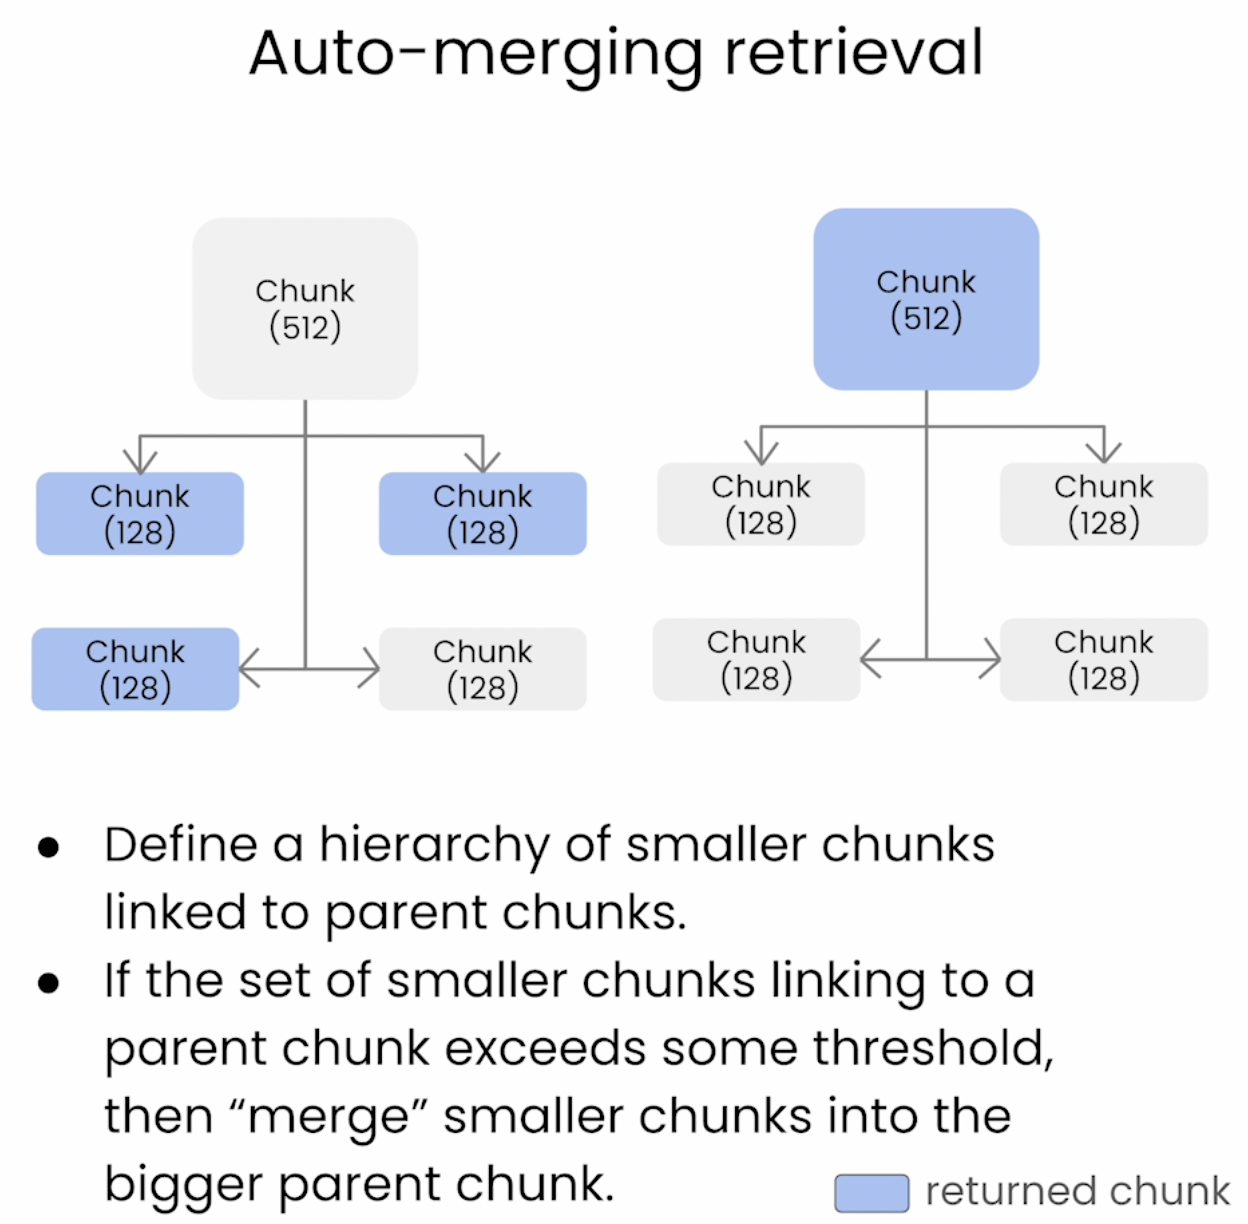

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import utils

import os
import openai
openai.api_key = utils.get_openai_api_key()

In [3]:
from llama_index import SimpleDirectoryReader

documents = SimpleDirectoryReader(
    input_files=["./eBook-How-to-Build-a-Career-in-AI.pdf"]
).load_data()

In [4]:
print(type(documents), "\n")
print(len(documents), "\n")
print(type(documents[0]))
print(documents[0])

<class 'list'> 

41 

<class 'llama_index.schema.Document'>
Doc ID: a0ee5493-9d0a-44f4-8256-e157b910bd3d
Text: PAGE 1Founder, DeepLearning.AICollected Insights from Andrew Ng
How to  Build Your Career in AIA Simple Guide


## Auto-merging retrieval setup

In [5]:
from llama_index import Document

document = Document(text="\n\n".join([doc.text for doc in documents]))

In [6]:
from llama_index.node_parser import HierarchicalNodeParser

# create the hierarchical node parser w/ default settings
node_parser = HierarchicalNodeParser.from_defaults(
    chunk_sizes=[2048, 512, 128]
)

[nltk_data] Downloading package punkt to /tmp/llama_index...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
nodes = node_parser.get_nodes_from_documents([document])

In [8]:
from llama_index.node_parser import get_leaf_nodes

leaf_nodes = get_leaf_nodes(nodes)
print(leaf_nodes[30].text)

But this became less important as numerical linear algebra libraries matured.
Deep learning is still an emerging technology, so when you train a neural network and the 
optimization algorithm struggles to converge, understanding the math behind gradient 
descent, momentum, and the Adam  optimization algorithm will help you make better decisions. 
Similarly, if your neural network does something funny — say, it makes bad predictions on 
images of a certain resolution, but not others — understanding the math behind neural network 
architectures puts you in a better position to figure out what to do.
Of course, I also encourage learning driven by curiosity.


In [9]:
nodes_by_id = {node.node_id: node for node in nodes}

parent_node = nodes_by_id[leaf_nodes[30].parent_node.node_id]
print(parent_node.text)

PAGE 12Should You 
Learn Math to 
Get a Job in AI? CHAPTER 3
LEARNING

PAGE 13Should you Learn Math to Get a Job in AI? CHAPTER 3
Is math a foundational skill for AI? It’s always nice to know more math! But there’s so much to 
learn that, realistically, it’s necessary to prioritize. Here’s how you might go about strengthening 
your math background.
To figure out what’s important to know, I find it useful to ask what you need to know to make 
the decisions required for the work you want to do. At DeepLearning.AI, we frequently ask, 
“What does someone need to know to accomplish their goals?” The goal might be building a 
machine learning model, architecting a system, or passing a job interview.
Understanding the math behind algorithms you use is often helpful, since it enables you to 
debug them. But the depth of knowledge that’s useful changes over time. As machine learning 
techniques mature and become more reliable and turnkey, they require less debugging, and a 
shallower understand

### Building the index

In [10]:
from llama_index.llms import OpenAI

llm = OpenAI(model="gpt-3.5-turbo", temperature=0.1)

In [11]:
from llama_index import ServiceContext

auto_merging_context = ServiceContext.from_defaults(
    llm=llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    node_parser=node_parser,
)

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
from llama_index import VectorStoreIndex, StorageContext

storage_context = StorageContext.from_defaults()
storage_context.docstore.add_documents(nodes)

automerging_index = VectorStoreIndex(
    leaf_nodes, storage_context=storage_context, service_context=auto_merging_context
)

automerging_index.storage_context.persist(persist_dir="./merging_index")

In [13]:
# This block of code is optional to check
# if an index file exist, then it will load it
# if not, it will rebuild it

import os
from llama_index import VectorStoreIndex, StorageContext, load_index_from_storage
from llama_index import load_index_from_storage

if not os.path.exists("./merging_index"):
    storage_context = StorageContext.from_defaults()
    storage_context.docstore.add_documents(nodes)

    automerging_index = VectorStoreIndex(
            leaf_nodes,
            storage_context=storage_context,
            service_context=auto_merging_context
        )

    automerging_index.storage_context.persist(persist_dir="./merging_index")
else:
    automerging_index = load_index_from_storage(
        StorageContext.from_defaults(persist_dir="./merging_index"),
        service_context=auto_merging_context
    )


### Defining the retriever and running the query engine

In [14]:
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.retrievers import AutoMergingRetriever
from llama_index.query_engine import RetrieverQueryEngine

automerging_retriever = automerging_index.as_retriever(
    similarity_top_k=12
)

retriever = AutoMergingRetriever(
    automerging_retriever, 
    automerging_index.storage_context, 
    verbose=True
)

rerank = SentenceTransformerRerank(top_n=6, model="BAAI/bge-reranker-base")

auto_merging_engine = RetrieverQueryEngine.from_args(
    automerging_retriever, node_postprocessors=[rerank]
)

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

In [15]:
auto_merging_response = auto_merging_engine.query(
    "What is the importance of networking in AI?"
)

In [16]:
from llama_index.response.notebook_utils import display_response

display_response(auto_merging_response)

**`Final Response:`** Networking in AI is crucial as it helps individuals build a strong professional community that can provide valuable information, support, and opportunities. By connecting with others in the field, individuals can receive help, advice, and referrals to potential employers. Additionally, networking can lead to collaborations, idea-sharing, and the chance to learn from domain experts, ultimately helping individuals advance their skills and expertise in AI.

## Putting it all Together

In [17]:
import os

from llama_index import (
    ServiceContext,
    StorageContext,
    VectorStoreIndex,
    load_index_from_storage,
)
from llama_index.node_parser import HierarchicalNodeParser
from llama_index.node_parser import get_leaf_nodes
from llama_index import StorageContext, load_index_from_storage
from llama_index.retrievers import AutoMergingRetriever
from llama_index.indices.postprocessor import SentenceTransformerRerank
from llama_index.query_engine import RetrieverQueryEngine


def build_automerging_index(
    documents,
    llm,
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="merging_index",
    chunk_sizes=None,
):
    chunk_sizes = chunk_sizes or [2048, 512, 128]
    node_parser = HierarchicalNodeParser.from_defaults(chunk_sizes=chunk_sizes)
    nodes = node_parser.get_nodes_from_documents(documents)
    leaf_nodes = get_leaf_nodes(nodes)
    merging_context = ServiceContext.from_defaults(
        llm=llm,
        embed_model=embed_model,
    )
    storage_context = StorageContext.from_defaults()
    storage_context.docstore.add_documents(nodes)

    if not os.path.exists(save_dir):
        automerging_index = VectorStoreIndex(
            leaf_nodes, storage_context=storage_context, service_context=merging_context
        )
        automerging_index.storage_context.persist(persist_dir=save_dir)
    else:
        automerging_index = load_index_from_storage(
            StorageContext.from_defaults(persist_dir=save_dir),
            service_context=merging_context,
        )
    return automerging_index


def get_automerging_query_engine(
    automerging_index,
    similarity_top_k=12,
    rerank_top_n=6,
):
    base_retriever = automerging_index.as_retriever(similarity_top_k=similarity_top_k)
    retriever = AutoMergingRetriever(
        base_retriever, automerging_index.storage_context, verbose=True
    )
    rerank = SentenceTransformerRerank(
        top_n=rerank_top_n, model="BAAI/bge-reranker-base"
    )
    auto_merging_engine = RetrieverQueryEngine.from_args(
        retriever, node_postprocessors=[rerank]
    )
    return auto_merging_engine

In [18]:
from llama_index.llms import OpenAI

index = build_automerging_index(
    [document],
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    save_dir="./merging_index",
)


In [19]:
query_engine = get_automerging_query_engine(index, similarity_top_k=6)

## TruLens Evaluation

In [20]:
from trulens_eval import Tru

Tru().reset_database()

🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of `Tru` to prevent this.


### Two layers

In [21]:
auto_merging_index_0 = build_automerging_index(
    documents,
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="merging_index_0",
    chunk_sizes=[2048,512],
)

In [22]:
auto_merging_engine_0 = get_automerging_query_engine(
    auto_merging_index_0,
    similarity_top_k=12,
    rerank_top_n=6,
)

In [23]:
from utils import get_prebuilt_trulens_recorder

tru_recorder = get_prebuilt_trulens_recorder(
    auto_merging_engine_0,
    app_id ='app_0'
)

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [24]:
eval_questions = []
with open('generated_questions.text', 'r') as file:
    for line in file:
        # Remove newline character and convert to integer
        item = line.strip()
        eval_questions.append(item)

In [25]:
def run_evals(eval_questions, tru_recorder, query_engine):
    for question in eval_questions:
        with tru_recorder as recording:
            response = query_engine.query(question)

In [26]:
run_evals(eval_questions, tru_recorder, auto_merging_engine_0)

> Merging 1 nodes into parent node.
> Parent node id: a29c876d-ba18-4469-bc41-8a76d8786859.
> Parent node text: PAGE 26If you’re considering a role switch, a startup can be an easier place to do it than a big ...

> Merging 1 nodes into parent node.
> Parent node id: 96d84c7c-f8c1-42bb-ae04-b30e832c7fce.
> Parent node text: PAGE 25Finding a job has a few predictable steps that include selecting the companies to which yo...

> Merging 1 nodes into parent node.
> Parent node id: 4edfdbfc-211c-4eb7-a8df-d04e54ecf80d.
> Parent node text: PAGE 33Choose who to work with. It’s tempting to take a position because of the projects you’ll w...

> Merging 1 nodes into parent node.
> Parent node id: 0bd0cc25-4679-4bc3-b2a8-2df7ef3aad62.
> Parent node text: PAGE 23Each project is only one step on a longer journey, hopefully one that has a positive impac...

> Merging 1 nodes into parent node.
> Parent node id: a0a07a3b-13c5-4e99-a153-5f7f2fc617b6.
> Parent node text: PAGE 29If you’re preparing to sw

> Merging 1 nodes into parent node.
> Parent node id: d0c88e43-da37-4c80-803b-d37912fd2b34.
> Parent node text: PAGE 13Should you Learn Math to Get a Job in AI? CHAPTER 3
Is math a foundational skill for AI? I...

> Merging 2 nodes into parent node.
> Parent node id: 8219fea7-df77-4d11-aa96-e1c612e41413.
> Parent node text: PAGE 9In the previous chapter, I introduced three key steps for building a career in AI: learning...

> Merging 1 nodes into parent node.
> Parent node id: 0a38d2f6-8873-4ca3-835c-e975a3c44e06.
> Parent node text: PAGE 4Coding AI Is the New Literacy
Today we take it for granted that many people know how to rea...

> Merging 1 nodes into parent node.
> Parent node id: 86d25a67-9027-4051-ad0d-bbc4336250dd.
> Parent node text: PAGE 10This is a lot to learn!
Even after you master everything on this list, I hope you’ll keep ...

> Merging 1 nodes into parent node.
> Parent node id: c503a5ad-3040-4566-9a98-05a94c01c095.
> Parent node text: PAGE 18It goes without saying th

> Merging 1 nodes into parent node.
> Parent node id: a0a07a3b-13c5-4e99-a153-5f7f2fc617b6.
> Parent node text: PAGE 29If you’re preparing to switch roles (say, taking a job as a machine learning engineer for ...

> Merging 1 nodes into parent node.
> Parent node id: 3deb0103-908d-438c-a2a1-e4e22200dfbc.
> Parent node text: PAGE 3Table of 
ContentsIntroduction: Coding AI is the New Literacy.
Chapter 1: Three Steps to Ca...

> Merging 1 nodes into parent node.
> Parent node id: 09e10cb1-166b-41ef-b301-f80c901c8f1e.
> Parent node text: PAGE 7These phases apply in a wide 
range of professions, but AI 
involves unique elements.
For e...

> Merging 1 nodes into parent node.
> Parent node id: c503a5ad-3040-4566-9a98-05a94c01c095.
> Parent node text: PAGE 18It goes without saying that we should only work on projects that are responsible, ethical,...

> Merging 1 nodes into parent node.
> Parent node id: 4edfdbfc-211c-4eb7-a8df-d04e54ecf80d.
> Parent node text: PAGE 33Choose who to work with. 

> Merging 1 nodes into parent node.
> Parent node id: 5082b068-38f3-438f-b9ba-ccbd000fcbc6.
> Parent node text: PAGE 38Before we dive into the final chapter of this book, I’d like to address the serious matter...

> Merging 1 nodes into parent node.
> Parent node id: 95f0cf6b-2bb9-46c1-b8fe-0ce7910bc327.
> Parent node text: PAGE 39My three-year-old daughter (who can barely count to 12) regularly tries to teach things to...

> Merging 1 nodes into parent node.
> Parent node id: 914b6e09-c8c0-43dd-9358-95d926d1256f.
> Parent node text: PAGE 37Overcoming Imposter 
SyndromeCHAPTER 11

> Merging 1 nodes into parent node.
> Parent node id: 3deb0103-908d-438c-a2a1-e4e22200dfbc.
> Parent node text: PAGE 3Table of 
ContentsIntroduction: Coding AI is the New Literacy.
Chapter 1: Three Steps to Ca...

> Merging 1 nodes into parent node.
> Parent node id: 3d74f448-c9f6-463e-b526-430f66dccec0.
> Parent node text: PAGE 35Keys to Building a Career in AI CHAPTER 10
The path to career success in AI is 

> Merging 1 nodes into parent node.
> Parent node id: c503a5ad-3040-4566-9a98-05a94c01c095.
> Parent node text: PAGE 18It goes without saying that we should only work on projects that are responsible, ethical,...

> Merging 1 nodes into parent node.
> Parent node id: ea26e31f-f4e8-498b-98cd-4a8126be6b1b.
> Parent node text: PAGE 16Determine milestones. Once you’ve deemed a project sufficiently 
valuable, the next step i...

> Merging 1 nodes into parent node.
> Parent node id: a24b26fd-e589-46b2-9cb8-933138c5326e.
> Parent node text: PAGE 22Over the course of a career, you’re likely to work on projects in succession, each growing...

> Merging 1 nodes into parent node.
> Parent node id: 3deb0103-908d-438c-a2a1-e4e22200dfbc.
> Parent node text: PAGE 3Table of 
ContentsIntroduction: Coding AI is the New Literacy.
Chapter 1: Three Steps to Ca...

> Merging 1 nodes into parent node.
> Parent node id: 09e10cb1-166b-41ef-b301-f80c901c8f1e.
> Parent node text: PAGE 7These phases apply in a wi

> Merging 1 nodes into parent node.
> Parent node id: 3deb0103-908d-438c-a2a1-e4e22200dfbc.
> Parent node text: PAGE 3Table of 
ContentsIntroduction: Coding AI is the New Literacy.
Chapter 1: Three Steps to Ca...

> Merging 1 nodes into parent node.
> Parent node id: 95f0cf6b-2bb9-46c1-b8fe-0ce7910bc327.
> Parent node text: PAGE 39My three-year-old daughter (who can barely count to 12) regularly tries to teach things to...

> Merging 1 nodes into parent node.
> Parent node id: 0d4cdb43-8586-431e-a4b3-8c81820653b3.
> Parent node text: PAGE 6The rapid rise of AI has led to a rapid rise in AI jobs, and many people are building excit...

> Merging 1 nodes into parent node.
> Parent node id: a3b0774a-d91d-44a0-82f5-84055b082369.
> Parent node text: PAGE 36Keys to Building a Career in AI CHAPTER 10
Of all the steps in building a career, this 
on...

> Merging 1 nodes into parent node.
> Parent node id: 3d74f448-c9f6-463e-b526-430f66dccec0.
> Parent node text: PAGE 35Keys to Building a Career

In [27]:
from trulens_eval import Tru

Tru().get_leaderboard(app_ids=[])

,Groundedness,Context Relevance,Answer Relevance,latency,total_cost
app_id,,,,,
app_0,1.0,0.255556,0.9875,3.916667,0.003667


In [28]:
Tru().run_dashboard()

Starting dashboard ...


Accordion(children=(VBox(children=(VBox(children=(Label(value='STDOUT'), Output())), VBox(children=(Label(valu…

Dashboard started at https://s172-29-41-146p38560.lab-aws-production.deeplearning.ai/ .


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

### Three layers

In [29]:
auto_merging_index_1 = build_automerging_index(
    documents,
    llm=OpenAI(model="gpt-3.5-turbo", temperature=0.1),
    embed_model="local:BAAI/bge-small-en-v1.5",
    save_dir="merging_index_1",
    chunk_sizes=[2048,512,128],
)

In [30]:
auto_merging_engine_1 = get_automerging_query_engine(
    auto_merging_index_1,
    similarity_top_k=12,
    rerank_top_n=6,
)


In [31]:
tru_recorder = get_prebuilt_trulens_recorder(
    auto_merging_engine_1,
    app_id ='app_1'
)

✅ In Answer Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Answer Relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In Context Relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In Context Relevance, input response will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input source will be set to __record__.app.query.rets.source_nodes[:].node.text .
✅ In Groundedness, input statement will be set to __record__.main_output or `Select.RecordOutput` .


In [32]:
run_evals(eval_questions, tru_recorder, auto_merging_engine_1)

> Merging 4 nodes into parent node.
> Parent node id: 84397609-c471-421c-b01e-d3e72169618b.
> Parent node text: PAGE 26If you’re considering a role switch, a startup can be an easier place to do it than a big ...

> Merging 5 nodes into parent node.
> Parent node id: f2fb9f2b-7d39-4e0c-80fb-86b0ffb8785d.
> Parent node text: PAGE 25Finding a job has a few predictable steps that include selecting the companies to which yo...

> Merging 1 nodes into parent node.
> Parent node id: 345cbae7-4e86-49ae-81dc-5aafad0fd40e.
> Parent node text: PAGE 26If you’re considering a role switch, a startup can be an easier place to do it than a big ...

> Merging 1 nodes into parent node.
> Parent node id: b9653928-185c-4604-92dd-291f97a25b7a.
> Parent node text: PAGE 25Finding a job has a few predictable steps that include selecting the companies to which yo...

> Merging 5 nodes into parent node.
> Parent node id: 5bfe2982-0a8f-4e5e-bc44-e39e8f9938d8.
> Parent node text: PAGE 27There’s a lot we don’t kn

> Merging 3 nodes into parent node.
> Parent node id: 9873f294-2705-4077-a94d-4e96a660e793.
> Parent node text: PAGE 39My three-year-old daughter (who can barely count to 12) regularly tries to teach things to...

> Merging 3 nodes into parent node.
> Parent node id: da5563a3-d204-4fdf-a460-05cd95e72c3a.
> Parent node text: PAGE 38Before we dive into the final chapter of this book, I’d like to address the serious matter...

> Merging 1 nodes into parent node.
> Parent node id: b0952f24-8b4d-4fa4-8611-89e73931219b.
> Parent node text: PAGE 37Overcoming Imposter 
SyndromeCHAPTER 11

> Merging 1 nodes into parent node.
> Parent node id: 1f072f0c-4065-4db5-af96-7a25783bd3cd.
> Parent node text: PAGE 39My three-year-old daughter (who can barely count to 12) regularly tries to teach things to...

> Merging 1 nodes into parent node.
> Parent node id: 97a1eba5-2b37-44a3-b150-31d5782660ba.
> Parent node text: PAGE 38Before we dive into the final chapter of this book, I’d like to address the ser

In [33]:
from trulens_eval import Tru

Tru().get_leaderboard(app_ids=[])

,Groundedness,Context Relevance,Answer Relevance,latency,total_cost
app_id,,,,,
app_0,0.813492,0.333333,0.987500,3.916667,0.003667
app_1,NaN,NaN,0.966667,3.916667,0.001896


In [34]:
Tru().run_dashboard()

Starting dashboard ...
Config file already exists. Skipping writing process.
Credentials file already exists. Skipping writing process.
Dashboard already running at path: https://s172-29-41-146p38560.lab-aws-production.deeplearning.ai/


<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>